In [4]:
import polars as pl
import polars.selectors as cs
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator, FormatStrFormatter, PercentFormatter
import numpy as np
import seaborn as sns
import lightgbm
from colorama import Fore, Style
from scipy.optimize import minimize

from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import cohen_kappa_score, ConfusionMatrixDisplay

target_labels = ['None', 'Mild', 'Moderate', 'Severe']

In [5]:
tmp =  pl.read_csv('../input/child-mind-institute-problematic-internet-use/train.csv')
tmp

shape: (3_960, 82)
┌──────────┬────────────┬────────────┬────────────┬───┬────────────┬────────────┬───────────┬──────┐
│ id       ┆ Basic_Demo ┆ Basic_Demo ┆ Basic_Demo ┆ … ┆ SDS-SDS_To ┆ PreInt_Edu ┆ PreInt_Ed ┆ sii  │
│ ---      ┆ s-Enroll_S ┆ s-Age      ┆ s-Sex      ┆   ┆ tal_T      ┆ Hx-Season  ┆ uHx-compu ┆ ---  │
│ str      ┆ eason      ┆ ---        ┆ ---        ┆   ┆ ---        ┆ ---        ┆ terintern ┆ i64  │
│          ┆ ---        ┆ i64        ┆ i64        ┆   ┆ i64        ┆ str        ┆ et_…      ┆      │
│          ┆ str        ┆            ┆            ┆   ┆            ┆            ┆ ---       ┆      │
│          ┆            ┆            ┆            ┆   ┆            ┆            ┆ i64       ┆      │
╞══════════╪════════════╪════════════╪════════════╪═══╪════════════╪════════════╪═══════════╪══════╡
│ 00008ff9 ┆ Fall       ┆ 5          ┆ 0          ┆ … ┆ null       ┆ Fall       ┆ 3         ┆ 2    │
│ 000fd460 ┆ Summer     ┆ 9          ┆ 0          ┆ … ┆ 64         ┆ Summer     ┆ 0         ┆ 0    │
│ 00105258 ┆ Summer     ┆ 10         ┆ 1          ┆ … ┆ 54         ┆ Summer     ┆ 2         ┆ 0    │
│ 00115b9f ┆ Winter     ┆ 9          ┆ 0          ┆ … ┆ 45         ┆ Winter     ┆ 0         ┆ 1    │
│ 0016bb22 ┆ Spring     ┆ 18         ┆ 1          ┆ … ┆ null       ┆ null       ┆ null      ┆ null │
│ …        ┆ …          ┆ …          ┆ …          ┆ … ┆ …          ┆ …          ┆ …         ┆ …    │
│ ff8a2de4 ┆ Fall       ┆ 13         ┆ 0          ┆ … ┆ 50         ┆ Fall       ┆ 1         ┆ 1    │
│ ffa9794a ┆ Winter     ┆ 10         ┆ 0          ┆ … ┆ null       ┆ Winter     ┆ 0         ┆ null │
│ ffcd4dbd ┆ Fall       ┆ 11         ┆ 0          ┆ … ┆ 77         ┆ Fall       ┆ 0         ┆ 1    │
│ ffed1dd5 ┆ Spring     ┆ 13         ┆ 0          ┆ … ┆ 47         ┆ Spring     ┆ 1         ┆ 0    │
│ ffef538e ┆ Spring     ┆ 11         ┆ 0          ┆ … ┆ null       ┆ Spring     ┆ 1         ┆ null │
└──────────┴────────────┴────────────┴────────────┴───┴────────────┴────────────┴───────────┴──────┘

# 数据预处理

## 1.存储优化

In [6]:
# 存储优化 转换字符型为枚举型
season_dtype = pl.Enum(['Spring', 'Summer', 'Fall', 'Winter'])

train = (
    pl.read_csv('../input/child-mind-institute-problematic-internet-use/train.csv')
    .with_columns(pl.col('^.*Season$').cast(season_dtype))
)

test = (
    pl.read_csv('../input/child-mind-institute-problematic-internet-use/test.csv')
    .with_columns(pl.col('^.*Season$').cast(season_dtype))
)

train

shape: (3_960, 82)
┌──────────┬────────────┬────────────┬────────────┬───┬────────────┬────────────┬───────────┬──────┐
│ id       ┆ Basic_Demo ┆ Basic_Demo ┆ Basic_Demo ┆ … ┆ SDS-SDS_To ┆ PreInt_Edu ┆ PreInt_Ed ┆ sii  │
│ ---      ┆ s-Enroll_S ┆ s-Age      ┆ s-Sex      ┆   ┆ tal_T      ┆ Hx-Season  ┆ uHx-compu ┆ ---  │
│ str      ┆ eason      ┆ ---        ┆ ---        ┆   ┆ ---        ┆ ---        ┆ terintern ┆ i64  │
│          ┆ ---        ┆ i64        ┆ i64        ┆   ┆ i64        ┆ enum       ┆ et_…      ┆      │
│          ┆ enum       ┆            ┆            ┆   ┆            ┆            ┆ ---       ┆      │
│          ┆            ┆            ┆            ┆   ┆            ┆            ┆ i64       ┆      │
╞══════════╪════════════╪════════════╪════════════╪═══╪════════════╪════════════╪═══════════╪══════╡
│ 00008ff9 ┆ Fall       ┆ 5          ┆ 0          ┆ … ┆ null       ┆ Fall       ┆ 3         ┆ 2    │
│ 000fd460 ┆ Summer     ┆ 9          ┆ 0          ┆ … ┆ 64         ┆ Summer     ┆ 0         ┆ 0    │
│ 00105258 ┆ Summer     ┆ 10         ┆ 1          ┆ … ┆ 54         ┆ Summer     ┆ 2         ┆ 0    │
│ 00115b9f ┆ Winter     ┆ 9          ┆ 0          ┆ … ┆ 45         ┆ Winter     ┆ 0         ┆ 1    │
│ 0016bb22 ┆ Spring     ┆ 18         ┆ 1          ┆ … ┆ null       ┆ null       ┆ null      ┆ null │
│ …        ┆ …          ┆ …          ┆ …          ┆ … ┆ …          ┆ …          ┆ …         ┆ …    │
│ ff8a2de4 ┆ Fall       ┆ 13         ┆ 0          ┆ … ┆ 50         ┆ Fall       ┆ 1         ┆ 1    │
│ ffa9794a ┆ Winter     ┆ 10         ┆ 0          ┆ … ┆ null       ┆ Winter     ┆ 0         ┆ null │
│ ffcd4dbd ┆ Fall       ┆ 11         ┆ 0          ┆ … ┆ 77         ┆ Fall       ┆ 0         ┆ 1    │
│ ffed1dd5 ┆ Spring     ┆ 13         ┆ 0          ┆ … ┆ 47         ┆ Spring     ┆ 1         ┆ 0    │
│ ffef538e ┆ Spring     ┆ 11         ┆ 0          ┆ … ┆ null       ┆ Spring     ┆ 1         ┆ null │
└──────────┴────────────┴────────────┴────────────┴───┴────────────┴────────────┴───────────┴──────┘

## 2.缺失值处理

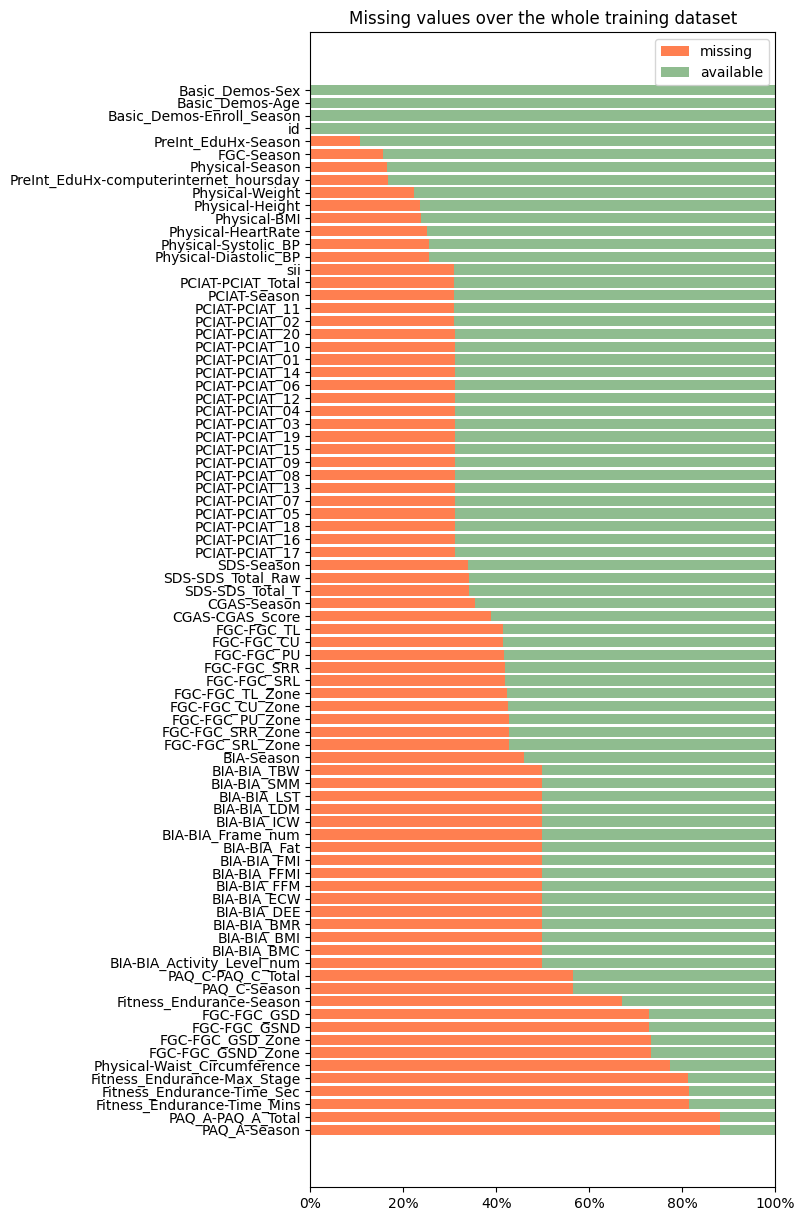

In [7]:
missing_count = (
    train
    .null_count()
    .transpose(include_header=True,
               header_name='feature',
               column_names=['null_count'])
    .sort('null_count', descending=True)
    .with_columns((pl.col('null_count') / len(train)).alias('null_ratio'))
)
plt.figure(figsize=(6, 15))
plt.title('Missing values over the whole training dataset')
plt.barh(np.arange(len(missing_count)), missing_count.get_column('null_ratio'), color='coral', label='missing')
plt.barh(np.arange(len(missing_count)), 
         1 - missing_count.get_column('null_ratio'),
         left=missing_count.get_column('null_ratio'),
         color='darkseagreen', label='available')
plt.yticks(np.arange(len(missing_count)), missing_count.get_column('feature'))
plt.gca().xaxis.set_major_formatter(PercentFormatter(xmax=1, decimals=0))
plt.xlim(0, 1)
plt.legend()
plt.show()

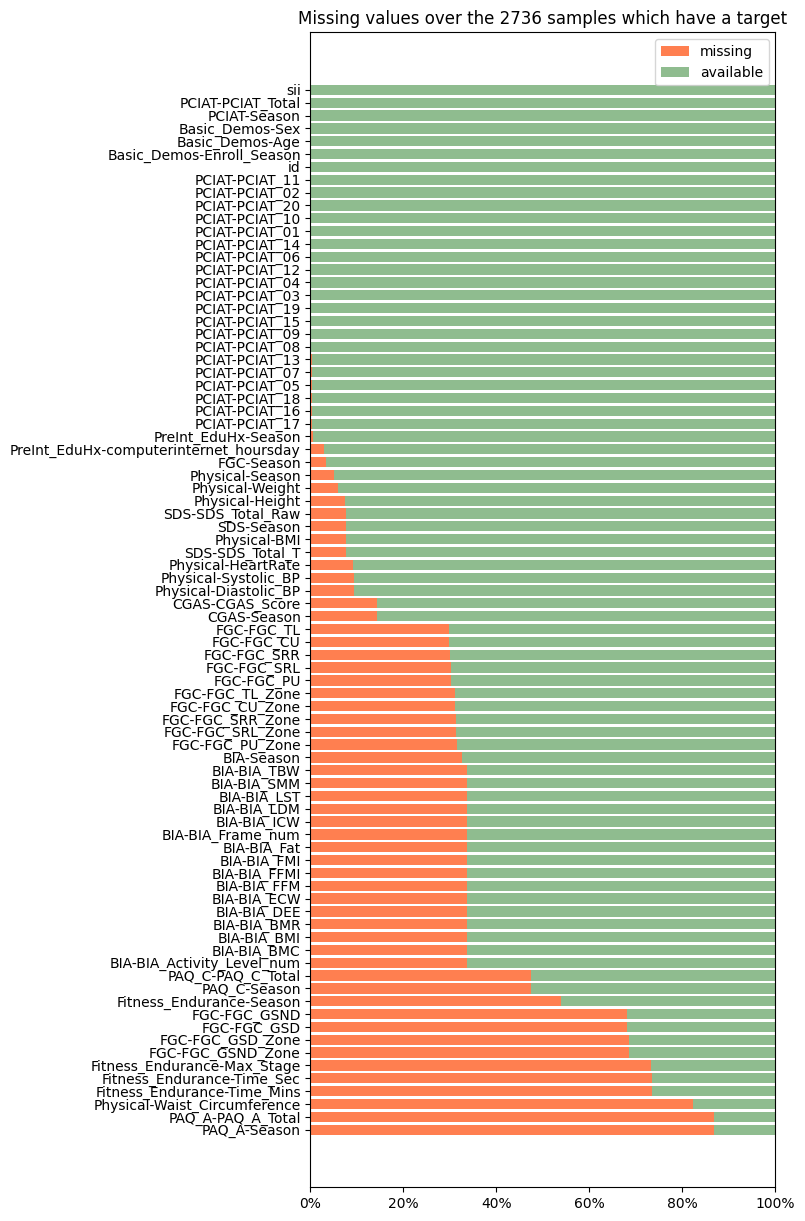

In [8]:
supervised_usable = (
    train
    .filter(pl.col('sii').is_not_null())
)
# 计算在有效记录中每个特征的缺失值数量
missing_count = (
    supervised_usable
    .null_count()  # 计算每列的缺失值数量
    .transpose(include_header=True,  # 转置数据，使特征名成为行
                header_name='feature',  # 指定转置后列的名称
                column_names=['null_count'])  # 指定新列的名称
    .sort('null_count', descending=True)  # 按缺失值数量降序排序
    .with_columns((pl.col('null_count') / len(supervised_usable)).alias('null_ratio'))  # 计算缺失值比率
)

# 绘制缺失值的条形图
plt.figure(figsize=(6, 15))  # 设置图形大小
plt.title(f'Missing values over the {len(supervised_usable)} samples which have a target')  # 设置标题
plt.barh(np.arange(len(missing_count)), missing_count.get_column('null_ratio'), color='coral', label='missing')  # 绘制缺失值的条形
plt.barh(np.arange(len(missing_count)), 
         1 - missing_count.get_column('null_ratio'),
         left=missing_count.get_column('null_ratio'),
         color='darkseagreen', label='available')  # 绘制可用值的条形，左侧为缺失值的条形
plt.yticks(np.arange(len(missing_count)), missing_count.get_column('feature'))  # 设置 y 轴刻度为特征名
plt.gca().xaxis.set_major_formatter(PercentFormatter(xmax=1, decimals=0))  # 格式化 x 轴为百分比
plt.xlim(0, 1)  # 设置 x 轴范围
plt.legend()  # 显示图例
plt.show()  # 显示图形

## 3.相关数据可视化

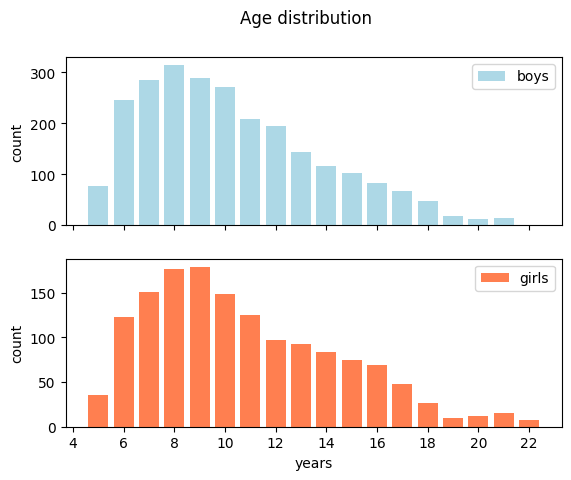

In [9]:
# 研究参与者年龄在5至22岁之间。男孩的数量是女孩的两倍。
_, axs = plt.subplots(2, 1, sharex=True)
for sex in range(2):
    ax = axs.ravel()[sex]
    # pl.col 是用于指定列的函数， 
    # .get_column('Basic_Demos-Age') 从筛选后的数据中提取 Basic_Demos-Age 列的数据。
    # .value_counts() 对提取的年龄列数据进行计数，返回每个唯一年龄值的出现次数。
    # 计算频率，获取某一列中各个值的分布情况。
    vc = train.filter(pl.col('Basic_Demos-Sex') == sex).get_column('Basic_Demos-Age').value_counts()
    ax.bar(vc.get_column('Basic_Demos-Age'),
           vc.get_column('count'),
           color=['lightblue', 'coral'][sex],
           label=['boys', 'girls'][sex])
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))
    ax.set_ylabel('count')
    ax.legend()
plt.suptitle('Age distribution')
axs.ravel()[1].set_xlabel('years')
plt.show()

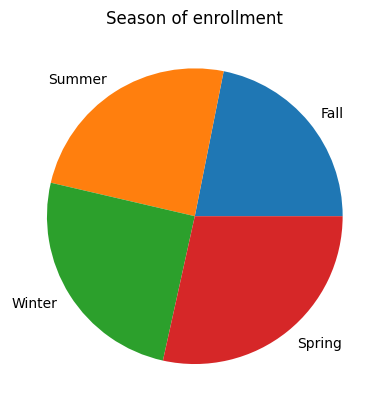

In [10]:
vc = train.get_column('Basic_Demos-Enroll_Season').value_counts()
plt.pie(vc.get_column('count'), labels=vc.get_column('Basic_Demos-Enroll_Season'))
plt.title('Season of enrollment')
plt.show()

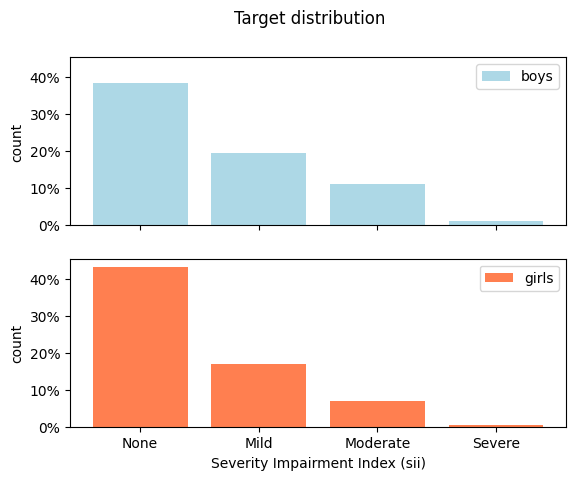

In [11]:
_, axs = plt.subplots(2, 1, sharex=True, sharey=True)
for sex in range(2):
    ax = axs.ravel()[sex]
    vc = train.filter(pl.col('Basic_Demos-Sex') == sex).get_column('sii').value_counts()
    ax.bar(vc.get_column('sii'),
           vc.get_column('count') / vc.get_column('count').sum(),
           color=['lightblue', 'coral'][sex],
           label=['boys', 'girls'][sex])
    ax.set_xticks(np.arange(4), target_labels)
    ax.yaxis.set_major_formatter(PercentFormatter(xmax=1, decimals=0))
    ax.set_ylabel('count')
    ax.legend()
plt.suptitle('Target distribution')
axs.ravel()[1].set_xlabel('Severity Impairment Index (sii)')
plt.show()

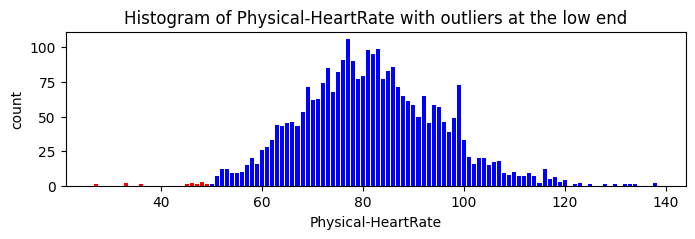

In [12]:
vc = train.get_column('Physical-HeartRate').value_counts()
color = np.where(vc.get_column('Physical-HeartRate') < 50, 'r', 'b')
plt.figure(figsize=(8, 2))
plt.title('Histogram of Physical-HeartRate with outliers at the low end')
plt.bar(vc.get_column('Physical-HeartRate'), vc.get_column('count'), color=color)
plt.xlabel('Physical-HeartRate')
plt.ylabel('count')
plt.show()

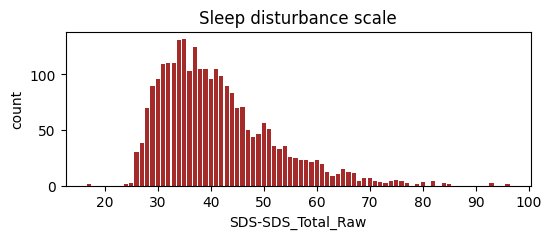

In [13]:
vc = train.get_column('SDS-SDS_Total_Raw').value_counts()
plt.figure(figsize=(6, 2))
plt.title('Sleep disturbance scale')
plt.bar(vc.get_column('SDS-SDS_Total_Raw'), vc.get_column('count'), color='brown')
plt.xlabel('SDS-SDS_Total_Raw')
plt.ylabel('count')
plt.show()

In [14]:
# 活动记录仪是一种监测人类休息/活动周期的非侵入性方法。一个小型活动记录仪，也称为活动测量传感器，佩戴一周或更长时间来测量总运动活动。该装置通常装在戴在手腕上的手表状包装中。活动记录仪单元所经历的运动会被连续记录下来，有些单元还会测量曝光量。（维基百科）
# 我们有四分之一参与者（准确地说是996人）的活动记录文件。文件名始终为part-0.parench。
# 查看参与者id=0417c91e的文件，这是一名6岁的右撇子女孩，我们看到该参与者在PCIAT测试后5天，即第二季度的星期二（工作日=2）的第二个44100（下午12:15）开始使用加速计。在PCIAT测试后的第53天，即第三季度的星期一上午9:08，她归还了加速计。
# 比赛数据页面显示，每天的时间格式为%H:%M:%S.%9f。这显然不是真的。从午夜开始，一天的时间以纳秒为单位进行测量。
actigraphy = pl.read_parquet('../input/child-mind-institute-problematic-internet-use/series_train.parquet/id=0417c91e/part-0.parquet')
actigraphy

shape: (287_179, 13)
┌────────┬───────────┬───────────┬───────────┬───┬──────────────┬─────────┬─────────┬──────────────┐
│ step   ┆ X         ┆ Y         ┆ Z         ┆ … ┆ time_of_day  ┆ weekday ┆ quarter ┆ relative_dat │
│ ---    ┆ ---       ┆ ---       ┆ ---       ┆   ┆ ---          ┆ ---     ┆ ---     ┆ e_PCIAT      │
│ u32    ┆ f32       ┆ f32       ┆ f32       ┆   ┆ i64          ┆ i8      ┆ i8      ┆ ---          │
│        ┆           ┆           ┆           ┆   ┆              ┆         ┆         ┆ f32          │
╞════════╪═══════════╪═══════════╪═══════════╪═══╪══════════════╪═════════╪═════════╪══════════════╡
│ 0      ┆ 0.014375  ┆ -0.020112 ┆ -0.995358 ┆ … ┆ 441000000000 ┆ 2       ┆ 2       ┆ 5.0          │
│        ┆           ┆           ┆           ┆   ┆ 00           ┆         ┆         ┆              │
│ 1      ┆ 0.014167  ┆ -0.023278 ┆ -0.996164 ┆ … ┆ 441050000000 ┆ 2       ┆ 2       ┆ 5.0          │
│        ┆           ┆           ┆           ┆   ┆ 00           ┆         ┆         ┆              │
│ 2      ┆ 0.014036  ┆ -0.022964 ┆ -0.99632  ┆ … ┆ 441100000000 ┆ 2       ┆ 2       ┆ 5.0          │
│        ┆           ┆           ┆           ┆   ┆ 00           ┆         ┆         ┆              │
│ 3      ┆ 0.013593  ┆ -0.022048 ┆ -0.996762 ┆ … ┆ 441150000000 ┆ 2       ┆ 2       ┆ 5.0          │
│        ┆           ┆           ┆           ┆   ┆ 00           ┆         ┆         ┆              │
│ 4      ┆ -0.061772 ┆ -0.065317 ┆ -0.973063 ┆ … ┆ 447800000000 ┆ 2       ┆ 2       ┆ 5.0          │
│        ┆           ┆           ┆           ┆   ┆ 00           ┆         ┆         ┆              │
│ …      ┆ …         ┆ …         ┆ …         ┆ … ┆ …            ┆ …       ┆ …       ┆ …            │
│ 287174 ┆ -0.407433 ┆ 0.091612  ┆ -0.377763 ┆ … ┆ 328750000000 ┆ 1       ┆ 3       ┆ 53.0         │
│        ┆           ┆           ┆           ┆   ┆ 00           ┆         ┆         ┆              │
│ 287175 ┆ -0.703572 ┆ 0.016187  ┆ 0.15956   ┆ … ┆ 328800000000 ┆ 1       ┆ 3       ┆ 53.0         │
│        ┆           ┆           ┆           ┆   ┆ 00           ┆         ┆         ┆              │
│ 287176 ┆ -0.209607 ┆ -0.4697   ┆ 0.636573  ┆ … ┆ 328850000000 ┆ 1       ┆ 3       ┆ 53.0         │
│        ┆           ┆           ┆           ┆   ┆ 00           ┆         ┆         ┆              │
│ 287177 ┆ -0.390378 ┆ 0.284386  ┆ 0.147654  ┆ … ┆ 328900000000 ┆ 1       ┆ 3       ┆ 53.0         │
│        ┆           ┆           ┆           ┆   ┆ 00           ┆         ┆         ┆              │
│ 287178 ┆ -0.48903  ┆ 0.179624  ┆ -0.509611 ┆ … ┆ 328950000000 ┆ 1       ┆ 3       ┆ 53.0         │
│        ┆           ┆           ┆           ┆   ┆ 00           ┆         ┆         ┆              │
└────────┴───────────┴───────────┴───────────┴───┴──────────────┴─────────┴─────────┴──────────────┘

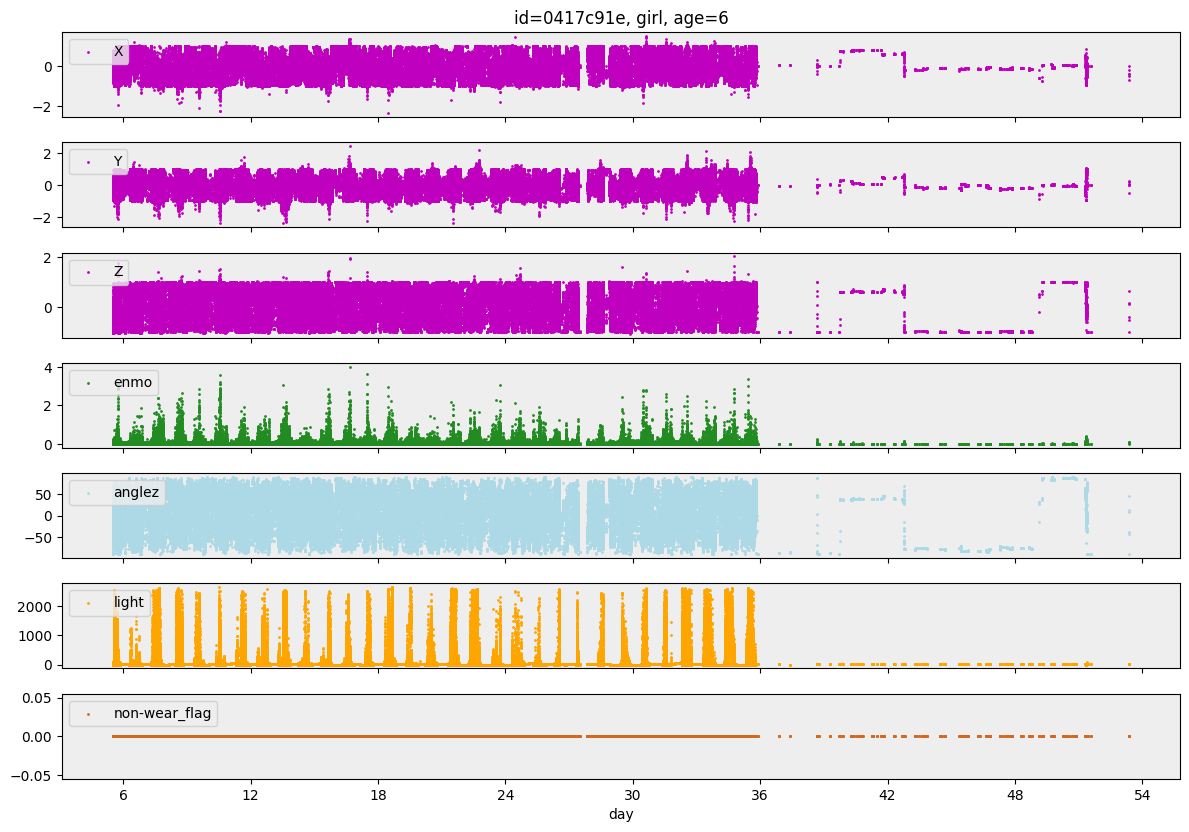

In [15]:
def analyze_actigraphy(id, only_one_week=False, small=False):
    actigraphy = pl.read_parquet(f'../input/child-mind-institute-problematic-internet-use/series_train.parquet/id={id}/part-0.parquet')
    # time_of_day 列（以纳秒为单位）转换为天数（通过除以 86400e9）
    day = actigraphy.get_column('relative_date_PCIAT') + actigraphy.get_column('time_of_day') / 86400e9
    # 筛选出 id 列等于变量 id 的行。
    sample = train.filter(pl.col('id') == id)
    # 筛选后的样本中获取年龄
    age = sample.get_column('Basic_Demos-Age').item()
    # 使用 item() 方法获取性别的索引（通常是 0 或 1），然后从 ['boy', 'girl'] 列表中取出对应的性别字符串。
    sex = ['boy', 'girl'][sample.get_column('Basic_Demos-Sex').item()]
    # 在 actigraphy 中添加两列：diff_seconds 和 norm。
    # day.diff() * 86400 计算 day 列的差异（即前后行之间的时间差），并将结果转换为秒数。
    actigraphy = (
        actigraphy
        .with_columns(
            (day.diff() * 86400).alias('diff_seconds'),
            # 计算三维空间中 X、Y、Z 的范数（即向量长度），结果命名为 norm。
            (np.sqrt(np.square(pl.col('X')) + np.square(pl.col('Y')) + np.square(pl.col('Z'))).alias('norm'))
        )
    )

    if only_one_week:
        # 获取 day 列的最小值，并向上取整，赋值给 start。这通常用于确定一周的开始日期。
        start = np.ceil(day.min())
        # 创建一个布尔掩码，筛选出在 start 到 start + 21（即 3 周）之间的日期。
        mask = (start <= day.to_numpy()) & (day.to_numpy() <= start + 7*3)
        # 进一步修改掩码，排除那些 non-wear_flag 为真的行（即不穿戴状态），将该列转换为布尔类型。
        mask &= ~ actigraphy.get_column('non-wear_flag').cast(bool).to_numpy()
    else:
        # 创建一个全为 True 的掩码，长度与 day 相同，这意味着不对数据进行任何筛选。
        mask = np.full(len(day), True)
        
    if small:
        timelines = [
            ('enmo', 'forestgreen'),
            ('light', 'orange'),
        ]
    else:
        timelines = [
            ('X', 'm'), #  表示三个方向的加速度数据，
            ('Y', 'm'),
            ('Z', 'm'),
#             ('norm', 'c'),
            ('enmo', 'forestgreen'),  #表示 ENMO（加速度数据的一种处理方式）
            ('anglez', 'lightblue'),  # 表示 Z 轴角度数据
            ('light', 'orange'), # 表示光强数据 
            ('non-wear_flag', 'chocolate') # 表示不穿戴状态，
    #         ('diff_seconds', 'k'),
        ]
        
    _, axs = plt.subplots(len(timelines), 1, sharex=True, figsize=(12, len(timelines) * 1.1 + 0.5))
    for ax, (feature, color) in zip(axs, timelines):
        ax.set_facecolor('#eeeeee')
        ax.scatter(day.to_numpy()[mask],
                   actigraphy.get_column(feature).to_numpy()[mask],
                   color=color, label=feature, s=1)
        ax.legend(loc='upper left', facecolor='#eeeeee')
        if feature == 'diff_seconds':
            ax.set_ylim(-0.5, 20.5)
    axs[-1].set_xlabel('day')
    axs[-1].xaxis.set_major_locator(MaxNLocator(integer=True))
    plt.tight_layout()
    axs[0].set_title(f'id={id}, {sex}, age={age}')
    plt.show()

analyze_actigraphy('0417c91e', only_one_week=False)

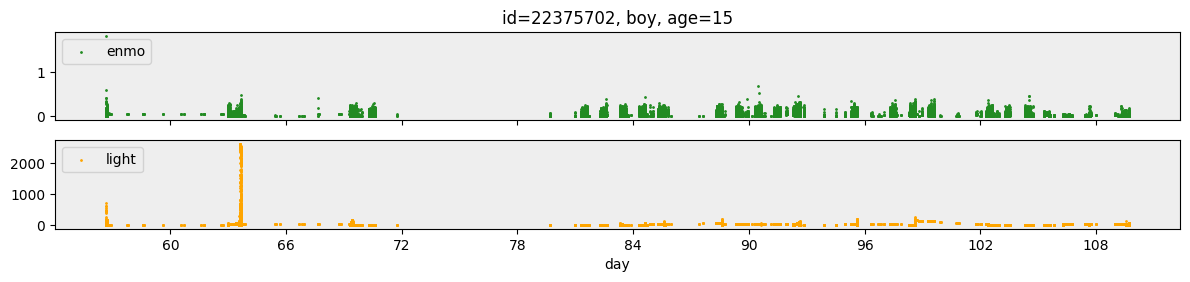

In [16]:
analyze_actigraphy('22375702', small=True)

# 特征工程

## 1.特征工程--生物/物理数据

In [17]:
def feature_engineering(df):
    season_cols = [col for col in df.columns if 'Season' in col]   
    df = df.drop(season_cols, axis=1)                              # 删除季节列
    # 创建新特征
    df['BMI_Age'] = df['Physical-BMI'] * df['Basic_Demos-Age']                                      #BMI和年龄的乘积
    df['Internet_Hours_Age'] = df['PreInt_EduHx-computerinternet_hoursday'] * df['Basic_Demos-Age'] #上网时长和年龄的乘积
    df['BMI_Internet_Hours'] = df['Physical-BMI'] * df['PreInt_EduHx-computerinternet_hoursday']    #BMI和上网时长的乘积 
    df['BFP_BMI'] = df['BIA-BIA_Fat'] / df['BIA-BIA_BMI']                                           #体脂和BMI的比值
    df['FFMI_BFP'] = df['BIA-BIA_FFMI'] / df['BIA-BIA_Fat']                                         #无脂体重和体脂的比值
    df['FMI_BFP'] = df['BIA-BIA_FMI'] / df['BIA-BIA_Fat']                                           #脂肪质量和体脂的比值
    df['LST_TBW'] = df['BIA-BIA_LST'] / df['BIA-BIA_TBW']                                           #瘦体重和总水分的比值
    df['BFP_BMR'] = df['BIA-BIA_Fat'] * df['BIA-BIA_BMR']                                           #体脂和基础代谢率的乘积
    df['BFP_DEE'] = df['BIA-BIA_Fat'] * df['BIA-BIA_DEE']                                           #体脂和日常消耗的乘积
    df['BMR_Weight'] = df['BIA-BIA_BMR'] / df['Physical-Weight']                                    #基础代谢率和体重的比值
    df['DEE_Weight'] = df['BIA-BIA_DEE'] / df['Physical-Weight']                                    #日常消耗和体重的比值
    df['SMM_Height'] = df['BIA-BIA_SMM'] / df['Physical-Height']                                    #肌肉量与身高的比值
    df['Muscle_to_Fat'] = df['BIA-BIA_SMM'] / df['BIA-BIA_FMI']                                     #肌肉与脂肪的比值
    df['Hydration_Status'] = df['BIA-BIA_TBW'] / df['Physical-Weight']                              #水合状态与体重的比值
    df['ICW_TBW'] = df['BIA-BIA_ICW'] / df['BIA-BIA_TBW']                                           #胞内水分和总体水分的比值
    df['BMI_PHR'] = df['Physical-BMI'] * df['Physical-HeartRate']                                   #BMI和心率的乘积
    
    return df

## 2.特征工程--时序数据

## 2.1安装tabnet

In [18]:
!pip -q install /kaggle/input/pytorchtabnet/pytorch_tabnet-4.1.0-py3-none-any.whl

/usr/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


In [19]:
from pytorch_tabnet.tab_model import TabNetRegressor
import torch
import numpy as np
import pandas as pd
import os
import re
from sklearn.base import clone
from sklearn.metrics import cohen_kappa_score
from sklearn.model_selection import StratifiedKFold
from scipy.optimize import minimize
from concurrent.futures import ThreadPoolExecutor
from tqdm import tqdm
import polars as pl
import polars.selectors as cs
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator, FormatStrFormatter, PercentFormatter
import seaborn as sns

from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from keras.models import Model
from keras.layers import Input, Dense
from keras.optimizers import Adam
import torch
import torch.nn as nn
import torch.optim as optim

from colorama import Fore, Style
from IPython.display import clear_output
import warnings
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from sklearn.ensemble import VotingRegressor, RandomForestRegressor, GradientBoostingRegressor
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.pipeline import Pipeline
warnings.filterwarnings('ignore')
pd.options.display.max_columns = None

In [20]:
import random
def seed_everything(seed):
    random.seed(seed)             #使用 NumPy 设置随机种子，以确保NumPy生成的随机数是可重复的。
    os.environ['PYTHONHASHSEED'] = str(seed) #将 PYTHONHASHSEED 环境变量设置为指定的种子。这有助于确保哈希函数的输出是可预测的。
    np.random.seed(seed)
    torch.manual_seed(seed)       #为CPU设置随机种子（如果可用）
    torch.cuda.manual_seed(seed)  #为GPU设置随机种子（如果可用）
    torch.backends.cudnn.deterministic = True  #保证每次运行时，卷积操作的结果是确定的。
    torch.backends.cudnn.benchmark = True      #启用基准模式，可能会影响性能，但在某些情况下会使结果更一致。
seed_everything(2024)             #传入 2024 作为种子值。这将保证在运行后续代码时，所有随机数生成器的行为都是可预测的。

In [21]:
SEED = 42
n_splits = 5

### 2.2整合数据

In [22]:
def process_file(filename, dirname):
    # 删去step列，重塑一维数据，返回文件名中等号后面的部分作为索引
    df = pd.read_parquet(os.path.join(dirname, filename, 'part-0.parquet'))
    df.drop('step', axis=1, inplace=True)
    return df.describe().values.reshape(-1), filename.split('=')[1]

def load_time_series(dirname) -> pd.DataFrame:
    # 并行处理文件
    ids = os.listdir(dirname)
    with ThreadPoolExecutor() as executor:
        results = list(tqdm(executor.map(lambda fname: process_file(fname, dirname), ids), total=len(ids)))
    
    stats, indexes = zip(*results)
    
    df = pd.DataFrame(stats, columns=[f"stat_{i}" for i in range(len(stats[0]))])
    df['id'] = indexes
    return df

### 2.3AutoEncoder降维

In [23]:
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
from sklearn.preprocessing import StandardScaler


class AutoEncoder(nn.Module):
    def __init__(self, input_dim, encoding_dim):
        super(AutoEncoder, self).__init__()
        self.encoder = nn.Sequential(                  #编码器 多个线性层和relu激活函数
            nn.Linear(input_dim, encoding_dim*3),
            nn.ReLU(),
            nn.Linear(encoding_dim*3, encoding_dim*2),
            nn.ReLU(),
            nn.Linear(encoding_dim*2, encoding_dim),
            nn.ReLU()
        )
        self.decoder = nn.Sequential(                  #解码器 恢复原始数据
            nn.Linear(encoding_dim, input_dim*2),
            nn.ReLU(),
            nn.Linear(input_dim*2, input_dim*3),
            nn.ReLU(),
            nn.Linear(input_dim*3, input_dim),
            nn.Sigmoid()
        )
        
    def forward(self, x):                             #前向传播 
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded


def perform_autoencoder(df, encoding_dim=50, epochs=50, batch_size=32):
    scaler = StandardScaler()                   # 数据标准化--均值为0，方差为1
    df_scaled = scaler.fit_transform(df)        
    
    data_tensor = torch.FloatTensor(df_scaled)  # 标准化后的数据转换成FloatTensor格式
    
    input_dim = data_tensor.shape[1]
    autoencoder = AutoEncoder(input_dim, encoding_dim)   # 创建AutoEncoder实例，输入维度和编码维度作为参数
    
    criterion = nn.MSELoss()                             # 使用MSE（均方误差）作为损失函数
    optimizer = optim.Adam(autoencoder.parameters())    # 使用Adam优化器更新模型参数
    
    for epoch in range(epochs):                           #对每个epoch进行循环，数据分批次处理，清零梯度
        for i in range(0, len(data_tensor), batch_size):  #进行前向传播，计算重构与原始输入的损失
            batch = data_tensor[i : i + batch_size]       
            optimizer.zero_grad()
            reconstructed = autoencoder(batch)
            loss = criterion(reconstructed, batch)
            loss.backward()                               #反向传播并更新参数
            optimizer.step()                           
             
        if (epoch + 1) % 10 == 0:                         #每10个epoch打印一次损失之以监控训练过程
            print(f'Epoch [{epoch + 1}/{epochs}], Loss: {loss.item():.4f}]')
                 
    with torch.no_grad():                      # 禁用梯度计算，得到编码后的数据
        encoded_data = autoencoder.encoder(data_tensor).numpy()    
        
    df_encoded = pd.DataFrame(encoded_data, columns=[f'Enc_{i + 1}' for i in range(encoded_data.shape[1])])
    
    return df_encoded

### 2.4 自定义缺失值处理模型

In [24]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LassoCV
from sklearn.base import clone
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from pytorch_tabnet.callbacks import Callback
import os
import torch
from tqdm import tqdm
# 加载数据集
train = pd.read_csv('/kaggle/input/child-mind-institute-problematic-internet-use/train.csv')
test = pd.read_csv('/kaggle/input/child-mind-institute-problematic-internet-use/test.csv')
sample = pd.read_csv('/kaggle/input/child-mind-institute-problematic-internet-use/sample_submission.csv')

# 加载时间序列数据
train_ts = load_time_series("/kaggle/input/child-mind-institute-problematic-internet-use/series_train.parquet")
test_ts = load_time_series("/kaggle/input/child-mind-institute-problematic-internet-use/series_test.parquet")

# 从时间序列数据中移除 'id' 列
df_train = train_ts.drop('id', axis=1)
df_test = test_ts.drop('id', axis=1)

# 使用自编码器对特征进行编码
train_ts_encoded = perform_autoencoder(df_train, encoding_dim=60, epochs=100, batch_size=32)
test_ts_encoded = perform_autoencoder(df_test, encoding_dim=60, epochs=100, batch_size=32)

# 将 'id' 列重新添加到编码后的数据框中
train_ts_encoded["id"] = train_ts["id"]
test_ts_encoded['id'] = test_ts["id"]

# 将编码后的特征与原始训练和测试数据集合并
train = pd.merge(train, train_ts_encoded, how="left", on='id')
test = pd.merge(test, test_ts_encoded, how="left", on='id')


# 定义插补类
class Impute_With_Model:
    def __init__(self, na_frac=0.5, min_samples=0):
        self.model_dict = {}  # 存储插补模型
        self.mean_dict = {}   # 存储特征均值
        self.features = None
        self.na_frac = na_frac
        self.min_samples = min_samples
        
    def find_features(self, data, feature, tmp_features):
        # 查找可用于插补的有效特征
        missing_rows = data[feature].isna()
        na_fraction = data[missing_rows][tmp_features].isna().mean(axis=0)
        valid_features = np.array(tmp_features)[na_fraction <= self.na_frac]
        return valid_features

    def fit_models(self, model, data, features):
        # 为每个缺失值特征拟合模型
        self.features = features
        for feature in features:
            self.mean_dict[feature] = np.mean(data[feature])
        for feature in tqdm(features):
            if data[feature].isna().sum() > 0:
                model_clone = clone(model)
                X = data[data[feature].notna()].copy()
                tmp_features = [f for f in features if f != feature]
                tmp_features = self.find_features(data, feature, tmp_features)
                if len(tmp_features) >= 1 and X.shape[0] > self.min_samples:
                    for f in tmp_features:
                        X[f] = X[f].fillna(self.mean_dict[f])
                    model_clone.fit(X[tmp_features], X[feature])
                    self.model_dict[feature] = (model_clone, tmp_features.copy())
                else:
                    self.model_dict[feature] = ("mean", np.mean(data[feature]))
            
    def impute(self, data):
        # 插补缺失值
        imputed_data = data.copy()
        for feature, model in self.model_dict.items():
            missing_rows = imputed_data[feature].isna()
            if missing_rows.any():
                if model[0] == "mean":
                    imputed_data[feature].fillna(model[1], inplace=True)
                else:
                    tmp_features = [f for f in self.features if f != feature]
                    X_missing = data.loc[missing_rows, tmp_features].copy()
                    for f in tmp_features:
                        X_missing[f] = X_missing[f].fillna(self.mean_dict[f])
                    imputed_data.loc[missing_rows, feature] = model[0].predict(X_missing[model[1]])
        return imputed_data

100%|██████████| 2/2 [00:00<00:00, 12.48it/s]


Epoch [10/100], Loss: 1.6709]
Epoch [20/100], Loss: 1.5267]
Epoch [30/100], Loss: 1.5090]
Epoch [40/100], Loss: 1.4952]
Epoch [50/100], Loss: 1.5067]
Epoch [60/100], Loss: 1.4682]
Epoch [70/100], Loss: 1.4416]
Epoch [80/100], Loss: 1.4349]
Epoch [90/100], Loss: 1.4065]
Epoch [100/100], Loss: 1.4026]
Epoch [10/100], Loss: 1.0070]
Epoch [20/100], Loss: 0.5783]
Epoch [30/100], Loss: 0.4271]
Epoch [40/100], Loss: 0.4271]
Epoch [50/100], Loss: 0.4271]
Epoch [60/100], Loss: 0.4271]
Epoch [70/100], Loss: 0.4271]
Epoch [80/100], Loss: 0.4271]
Epoch [90/100], Loss: 0.4271]
Epoch [100/100], Loss: 0.4271]


### 2.5 引入KNN插补

In [25]:
train = pd.read_csv('/kaggle/input/child-mind-institute-problematic-internet-use/train.csv')
test = pd.read_csv('/kaggle/input/child-mind-institute-problematic-internet-use/test.csv')
sample = pd.read_csv('/kaggle/input/child-mind-institute-problematic-internet-use/sample_submission.csv')
# 加载时间序列数据
train_ts = load_time_series("/kaggle/input/child-mind-institute-problematic-internet-use/series_train.parquet")
test_ts = load_time_series("/kaggle/input/child-mind-institute-problematic-internet-use/series_test.parquet")
# 时间序列中删除id列，分别存储为df_train和df_test
df_train = train_ts.drop('id', axis=1)
df_test = test_ts.drop('id', axis=1)
# 对训练集和测试集用autoencoder 生成编码后的特征
train_ts_encoded = perform_autoencoder(df_train, encoding_dim=60, epochs=100, batch_size=32)
test_ts_encoded = perform_autoencoder(df_test, encoding_dim=60, epochs=100, batch_size=32)
# 获取编码后的列表名称并将id添加回编码后的数据框中
time_series_cols = train_ts_encoded.columns.tolist()
train_ts_encoded["id"]=train_ts["id"]
test_ts_encoded['id']=test_ts["id"]
# 编码后的特征与原训练集和测试集按id列进行左连接，更新train和test数据框
train = pd.merge(train, train_ts_encoded, how="left", on='id')
test = pd.merge(test, test_ts_encoded, how="left", on='id')
# 初始化KNN填充器 邻居设为5，选择训练集中所有数值型
imputer = KNNImputer(n_neighbors=5)
numeric_cols = train.select_dtypes(include=['float64', 'int64']).columns
imputed_data = imputer.fit_transform(train[numeric_cols])
train_imputed = pd.DataFrame(imputed_data, columns=numeric_cols)     # 用KNN对数值型列进行缺失值填充
train_imputed['sii'] = train_imputed['sii'].round().astype(int)      #将sii列的值四舍五入并转换为整数类型
for col in train.columns:               # 原训练集中的非数值型列添加到填充后的数据框中
    if col not in numeric_cols:
        train_imputed[col] = train[col]
# 更新train数据        
train = train_imputed
# 分别对训练集和测试集应用特征工程  生成新特征。从训练集中删除缺少10个及以上非缺失值的行
train = feature_engineering(train)
train = train.dropna(thresh=10, axis=0)
test = feature_engineering(test)
# 删除id列进行模型训练
train = train.drop('id', axis=1)
test  = test .drop('id', axis=1)   

# 特征列的 列表，包含模型训练所需的所有特征
featuresCols = ['Basic_Demos-Age', 'Basic_Demos-Sex',
                'CGAS-CGAS_Score', 'Physical-BMI',
                'Physical-Height', 'Physical-Weight', 'Physical-Waist_Circumference',
                'Physical-Diastolic_BP', 'Physical-HeartRate', 'Physical-Systolic_BP',
                'Fitness_Endurance-Max_Stage',
                'Fitness_Endurance-Time_Mins', 'Fitness_Endurance-Time_Sec',
                'FGC-FGC_CU', 'FGC-FGC_CU_Zone', 'FGC-FGC_GSND',
                'FGC-FGC_GSND_Zone', 'FGC-FGC_GSD', 'FGC-FGC_GSD_Zone', 'FGC-FGC_PU',
                'FGC-FGC_PU_Zone', 'FGC-FGC_SRL', 'FGC-FGC_SRL_Zone', 'FGC-FGC_SRR',
                'FGC-FGC_SRR_Zone', 'FGC-FGC_TL', 'FGC-FGC_TL_Zone',
                'BIA-BIA_Activity_Level_num', 'BIA-BIA_BMC', 'BIA-BIA_BMI',
                'BIA-BIA_BMR', 'BIA-BIA_DEE', 'BIA-BIA_ECW', 'BIA-BIA_FFM',
                'BIA-BIA_FFMI', 'BIA-BIA_FMI', 'BIA-BIA_Fat', 'BIA-BIA_Frame_num',
                'BIA-BIA_ICW', 'BIA-BIA_LDM', 'BIA-BIA_LST', 'BIA-BIA_SMM',
                'BIA-BIA_TBW', 'PAQ_A-PAQ_A_Total',
                'PAQ_C-PAQ_C_Total', 'SDS-SDS_Total_Raw',
                'SDS-SDS_Total_T',
                'PreInt_EduHx-computerinternet_hoursday', 'sii', 'BMI_Age','Internet_Hours_Age','BMI_Internet_Hours',
                'BFP_BMI', 'FFMI_BFP', 'FMI_BFP', 'LST_TBW', 'BFP_BMR', 'BFP_DEE', 'BMR_Weight', 'DEE_Weight',
                'SMM_Height', 'Muscle_to_Fat', 'Hydration_Status', 'ICW_TBW','BMI_PHR']
# 时间序列编码后的列名添加到新特征列列表中
featuresCols += time_series_cols
# 从训练集中选择特征列，删除sii列中缺失值的行
train = train[featuresCols]
train = train.dropna(subset='sii')
# 新的特征列列表
featuresCols = ['Basic_Demos-Age', 'Basic_Demos-Sex',
                'CGAS-CGAS_Score', 'Physical-BMI',
                'Physical-Height', 'Physical-Weight', 'Physical-Waist_Circumference',
                'Physical-Diastolic_BP', 'Physical-HeartRate', 'Physical-Systolic_BP',
                'Fitness_Endurance-Max_Stage',
                'Fitness_Endurance-Time_Mins', 'Fitness_Endurance-Time_Sec',
                'FGC-FGC_CU', 'FGC-FGC_CU_Zone', 'FGC-FGC_GSND',
                'FGC-FGC_GSND_Zone', 'FGC-FGC_GSD', 'FGC-FGC_GSD_Zone', 'FGC-FGC_PU',
                'FGC-FGC_PU_Zone', 'FGC-FGC_SRL', 'FGC-FGC_SRL_Zone', 'FGC-FGC_SRR',
                'FGC-FGC_SRR_Zone', 'FGC-FGC_TL', 'FGC-FGC_TL_Zone',
                'BIA-BIA_Activity_Level_num', 'BIA-BIA_BMC', 'BIA-BIA_BMI',
                'BIA-BIA_BMR', 'BIA-BIA_DEE', 'BIA-BIA_ECW', 'BIA-BIA_FFM',
                'BIA-BIA_FFMI', 'BIA-BIA_FMI', 'BIA-BIA_Fat', 'BIA-BIA_Frame_num',
                'BIA-BIA_ICW', 'BIA-BIA_LDM', 'BIA-BIA_LST', 'BIA-BIA_SMM',
                'BIA-BIA_TBW', 'PAQ_A-PAQ_A_Total',
                'PAQ_C-PAQ_C_Total', 'SDS-SDS_Total_Raw',
                'SDS-SDS_Total_T',
                'PreInt_EduHx-computerinternet_hoursday', 'BMI_Age','Internet_Hours_Age','BMI_Internet_Hours',
                'BFP_BMI', 'FFMI_BFP', 'FMI_BFP', 'LST_TBW', 'BFP_BMR', 'BFP_DEE', 'BMR_Weight', 'DEE_Weight',
                'SMM_Height', 'Muscle_to_Fat', 'Hydration_Status', 'ICW_TBW','BMI_PHR']
#时间序列编码后的列名添加到测试集特征列中，从测试集中选择这些特征。
featuresCols += time_series_cols
test = test[featuresCols]

100%|██████████| 2/2 [00:00<00:00, 11.38it/s]


Epoch [10/100], Loss: 1.6134]
Epoch [20/100], Loss: 1.5378]
Epoch [30/100], Loss: 1.5044]
Epoch [40/100], Loss: 1.4883]
Epoch [50/100], Loss: 1.4753]
Epoch [60/100], Loss: 1.4727]
Epoch [70/100], Loss: 1.4688]
Epoch [80/100], Loss: 1.4693]
Epoch [90/100], Loss: 1.4516]
Epoch [100/100], Loss: 1.4280]
Epoch [10/100], Loss: 0.9973]
Epoch [20/100], Loss: 0.5802]
Epoch [30/100], Loss: 0.4271]
Epoch [40/100], Loss: 0.4271]
Epoch [50/100], Loss: 0.4271]
Epoch [60/100], Loss: 0.4271]
Epoch [70/100], Loss: 0.4271]
Epoch [80/100], Loss: 0.4271]
Epoch [90/100], Loss: 0.4271]
Epoch [100/100], Loss: 0.4271]


In [26]:
print("Training columns:", train.columns.tolist())

Training columns: ['Basic_Demos-Age', 'Basic_Demos-Sex', 'CGAS-CGAS_Score', 'Physical-BMI', 'Physical-Height', 'Physical-Weight', 'Physical-Waist_Circumference', 'Physical-Diastolic_BP', 'Physical-HeartRate', 'Physical-Systolic_BP', 'Fitness_Endurance-Max_Stage', 'Fitness_Endurance-Time_Mins', 'Fitness_Endurance-Time_Sec', 'FGC-FGC_CU', 'FGC-FGC_CU_Zone', 'FGC-FGC_GSND', 'FGC-FGC_GSND_Zone', 'FGC-FGC_GSD', 'FGC-FGC_GSD_Zone', 'FGC-FGC_PU', 'FGC-FGC_PU_Zone', 'FGC-FGC_SRL', 'FGC-FGC_SRL_Zone', 'FGC-FGC_SRR', 'FGC-FGC_SRR_Zone', 'FGC-FGC_TL', 'FGC-FGC_TL_Zone', 'BIA-BIA_Activity_Level_num', 'BIA-BIA_BMC', 'BIA-BIA_BMI', 'BIA-BIA_BMR', 'BIA-BIA_DEE', 'BIA-BIA_ECW', 'BIA-BIA_FFM', 'BIA-BIA_FFMI', 'BIA-BIA_FMI', 'BIA-BIA_Fat', 'BIA-BIA_Frame_num', 'BIA-BIA_ICW', 'BIA-BIA_LDM', 'BIA-BIA_LST', 'BIA-BIA_SMM', 'BIA-BIA_TBW', 'PAQ_A-PAQ_A_Total', 'PAQ_C-PAQ_C_Total', 'SDS-SDS_Total_Raw', 'SDS-SDS_Total_T', 'PreInt_EduHx-computerinternet_hoursday', 'sii', 'BMI_Age', 'Internet_Hours_Age', 'BMI_Int

In [27]:
print("Testing columns:", test.columns.tolist())

Testing columns: ['Basic_Demos-Age', 'Basic_Demos-Sex', 'CGAS-CGAS_Score', 'Physical-BMI', 'Physical-Height', 'Physical-Weight', 'Physical-Waist_Circumference', 'Physical-Diastolic_BP', 'Physical-HeartRate', 'Physical-Systolic_BP', 'Fitness_Endurance-Max_Stage', 'Fitness_Endurance-Time_Mins', 'Fitness_Endurance-Time_Sec', 'FGC-FGC_CU', 'FGC-FGC_CU_Zone', 'FGC-FGC_GSND', 'FGC-FGC_GSND_Zone', 'FGC-FGC_GSD', 'FGC-FGC_GSD_Zone', 'FGC-FGC_PU', 'FGC-FGC_PU_Zone', 'FGC-FGC_SRL', 'FGC-FGC_SRL_Zone', 'FGC-FGC_SRR', 'FGC-FGC_SRR_Zone', 'FGC-FGC_TL', 'FGC-FGC_TL_Zone', 'BIA-BIA_Activity_Level_num', 'BIA-BIA_BMC', 'BIA-BIA_BMI', 'BIA-BIA_BMR', 'BIA-BIA_DEE', 'BIA-BIA_ECW', 'BIA-BIA_FFM', 'BIA-BIA_FFMI', 'BIA-BIA_FMI', 'BIA-BIA_Fat', 'BIA-BIA_Frame_num', 'BIA-BIA_ICW', 'BIA-BIA_LDM', 'BIA-BIA_LST', 'BIA-BIA_SMM', 'BIA-BIA_TBW', 'PAQ_A-PAQ_A_Total', 'PAQ_C-PAQ_C_Total', 'SDS-SDS_Total_Raw', 'SDS-SDS_Total_T', 'PreInt_EduHx-computerinternet_hoursday', 'BMI_Age', 'Internet_Hours_Age', 'BMI_Internet_Ho

# 模型训练和评估

In [28]:
#检查train中是否有inf/-inf的值，如果存在就转化成NAN
if np.any(np.isinf(train)):
    train = train.replace([np.inf, -np.inf], np.nan)
#定义一个函数计算K系数，用于评估分类模型性能 
def quadratic_weighted_kappa(y_true, y_pred):
    return cohen_kappa_score(y_true, y_pred, weights='quadratic')  # 权重定义为quadratic:意味错误分类的惩罚是平方级别的
#用于将非整型预测结果根据给定的阈值进行四舍五入
def threshold_Rounder(oof_non_rounded, thresholds):
    return np.where(oof_non_rounded < thresholds[0], 0,
                    np.where(oof_non_rounded < thresholds[1], 1,
                             np.where(oof_non_rounded < thresholds[2], 2, 3)))
#评估模型预测的质量（阈值，真实标签，四舍五入的预测值）
def evaluate_predictions(thresholds, y_true, oof_non_rounded):
    rounded_p = threshold_Rounder(oof_non_rounded, thresholds)   #将四舍五入的值转换为整数标签
    return -quadratic_weighted_kappa(y_true, rounded_p)        #计算真实标签和四舍五入后的预测标签之间的Kappa评分，并返回其负值，以便在优化时最小化该评分

## 自定义TrainML

In [29]:
# 用于训练机器学习模型的函数TrainML,并对模型进行交叉验证和预测
def TrainML(model_class, test_data):   # 两个参数：模型类+测试数据
    X = train.drop(['sii'], axis=1)    # 特征集
    y = train['sii']                   #目标变量
# 初始化分层K折交叉验证对象StratifieldFold，将数据划分为n_splits份，并随机打乱
    SKF = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=SEED)
# 创建两个空列表 用于存储每折的Kappa评分    
    train_S = []
    test_S = []
# 初始化三个数组    
    oof_non_rounded = np.zeros(len(y), dtype=float)    #存储每个折的验证集预测值（未四舍五入）
    oof_rounded = np.zeros(len(y), dtype=int)          #存储每个折的验证集预测值（四舍五入）
    test_preds = np.zeros((len(test_data), n_splits))  #存储每个折的测试数据的预测结果
#使用tqdm显示训练折的进度 遍历每个折的索引，train_idx和test_idx是索引
    for fold, (train_idx, test_idx) in enumerate(tqdm(SKF.split(X, y), desc="Training Folds", total=n_splits)):
        X_train, X_val = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_val = y.iloc[train_idx], y.iloc[test_idx]
# 克隆实例，并用训练集数据拟合模型
        model = clone(model_class)
        model.fit(X_train, y_train)
# 对训练集和验证集进行预测，分别存储结果
        y_train_pred = model.predict(X_train)
        y_val_pred = model.predict(X_val)
# 将验证集的未四舍五入预测值存入 oof_non_rounded。
# 对验证集的预测结果进行四舍五入并转换为整数，存入 oof_rounded。
        oof_non_rounded[test_idx] = y_val_pred
        y_val_pred_rounded = y_val_pred.round(0).astype(int)
        oof_rounded[test_idx] = y_val_pred_rounded
# 将训练和验证的 Kappa 评分添加到各自的列表中。
        train_kappa = quadratic_weighted_kappa(y_train, y_train_pred.round(0).astype(int))
        val_kappa = quadratic_weighted_kappa(y_val, y_val_pred_rounded)
# 计算训练集和验证集的二次加权 Kappa 评分
        train_S.append(train_kappa)
        test_S.append(val_kappa)
        
        test_preds[:, fold] = model.predict(test_data)
# 对测试数据进行预测，并将结果存入 test_preds 的当前折        
        print(f"Fold {fold+1} - Train QWK: {train_kappa:.4f}, Validation QWK: {val_kappa:.4f}")
        clear_output(wait=True)

    print(f"Mean Train QWK --> {np.mean(train_S):.4f}")
    print(f"Mean Validation QWK ---> {np.mean(test_S):.4f}")
#使用 minimize 函数来优化预测阈值，初始值为 [0.5, 1.5, 2.5]，目标是最小化 evaluate_predictions 函数的返回值。
    KappaOPtimizer = minimize(evaluate_predictions,
                              x0=[0.5, 1.5, 2.5], args=(y, oof_non_rounded), 
                              method='Nelder-Mead')
    assert KappaOPtimizer.success, "Optimization did not converge."
#检查优化是否成功，如果不成功，则抛出异常。   
#使用优化得到的阈值对未四舍五入的预测值进行四舍五入，得到调整后的预测结果。
    oof_tuned = threshold_Rounder(oof_non_rounded, KappaOPtimizer.x)
#计算优化后的 Kappa 评分。
    tKappa = quadratic_weighted_kappa(y, oof_tuned)

    print(f"----> || Optimized QWK SCORE :: {Fore.CYAN}{Style.BRIGHT} {tKappa:.3f}{Style.RESET_ALL}")
#对测试预测结果取平均，得到 tpm，并使用优化后的阈值进行四舍五入，得到调整后的测试预测值 tpTuned。
    tpm = test_preds.mean(axis=1)
    tpTuned = threshold_Rounder(tpm, KappaOPtimizer.x)
#创建一个提交数据框 submission，包含样本 ID 和优化后的预测值。    
    submission = pd.DataFrame({
        'id': sample['id'],
        'sii': tpTuned
    })

    return submission

# 综合模型

## 1.自定义Tabnet

In [30]:
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from pytorch_tabnet.callbacks import Callback
import os
import torch
from pytorch_tabnet.callbacks import Callback

In [31]:
class TabNetWrapper(BaseEstimator, RegressorMixin):
    def __init__(self, **kwargs):
        self.model = TabNetRegressor(**kwargs)
        self.kwargs = kwargs
        self.imputer = SimpleImputer(strategy='median')
        self.best_model_path = 'best_tabnet_model.pt'
        
    def fit(self, X, y):
        # Handle missing values
        X_imputed = self.imputer.fit_transform(X)
        
        if hasattr(y, 'values'):
            y = y.values
            
        # Create internal validation set
        X_train, X_valid, y_train, y_valid = train_test_split(
            X_imputed, 
            y, 
            test_size=0.2,
            random_state=42
        )
        
        # Train TabNet model
        history = self.model.fit(
            X_train=X_train,
            y_train=y_train.reshape(-1, 1),
            eval_set=[(X_valid, y_valid.reshape(-1, 1))],
            eval_name=['valid'],
            eval_metric=['mse'],
            max_epochs=200,
            patience=20,
            batch_size=1024,
            virtual_batch_size=128,
            num_workers=0,
            drop_last=False,
            callbacks=[
                TabNetPretrainedModelCheckpoint(
                    filepath=self.best_model_path,
                    monitor='valid_mse',
                    mode='min',
                    save_best_only=True,
                    verbose=True
                )
            ]
        )
        
        # Load the best model
        if os.path.exists(self.best_model_path):
            self.model.load_model(self.best_model_path)
            os.remove(self.best_model_path)  # Remove temporary file

        # Reflect feature importances to the wrapper class
        self.feature_importances_ = self.model.feature_importances_
        
        return self
    
    def predict(self, X):
        X_imputed = self.imputer.transform(X)
        return self.model.predict(X_imputed).flatten()
    
    def __deepcopy__(self, memo):
        # Add deepcopy support for scikit-learn
        cls = self.__class__
        result = cls.__new__(cls)
        memo[id(self)] = result
        for k, v in self.__dict__.items():
            setattr(result, k, deepcopy(v, memo))
        return result

# TabNet hyperparameters
TabNet_Params = {
    'n_d': 64,              # Width of the decision prediction layer
    'n_a': 64,              # Width of the attention embedding for each step
    'n_steps': 5,           # Number of steps in the architecture
    'gamma': 1.5,           # Coefficient for feature selection regularization
    'n_independent': 2,     # Number of independent GLU layers in each GLU block
    'n_shared': 2,          # Number of shared GLU layers in each GLU block
    'lambda_sparse': 1e-4,  # Sparsity regularization
    'optimizer_fn': torch.optim.Adam,
    'optimizer_params': dict(lr=2e-2, weight_decay=1e-5),
    'mask_type': 'entmax',
    'scheduler_params': dict(mode="min", patience=10, min_lr=1e-5, factor=0.5),
    'scheduler_fn': torch.optim.lr_scheduler.ReduceLROnPlateau,
    'verbose': 1,
    'device_name': 'cuda' if torch.cuda.is_available() else 'cpu'
}

class TabNetPretrainedModelCheckpoint(Callback):
    def __init__(self, filepath, monitor='val_loss', mode='min', 
                 save_best_only=True, verbose=1):
        super().__init__()  # Initialize parent class
        self.filepath = filepath
        self.monitor = monitor
        self.mode = mode
        self.save_best_only = save_best_only
        self.verbose = verbose
        self.best = float('inf') if mode == 'min' else -float('inf')
        
    def on_train_begin(self, logs=None):
        self.model = self.trainer  # Use trainer itself as model
        
    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        current = logs.get(self.monitor)
        if current is None:
            return
        
        # Check if current metric is better than best
        if (self.mode == 'min' and current < self.best) or \
           (self.mode == 'max' and current > self.best):
            if self.verbose:
                print(f'\nEpoch {epoch}: {self.monitor} improved from {self.best:.4f} to {current:.4f}')
            self.best = current
            if self.save_best_only:
                self.model.save_model(self.filepath)  # Save the entire model

## 2.机器学习模型

## 2.1超参选取

In [32]:
# Model parameters for LightGBM
Params = {
    'learning_rate': 0.046,
    'max_depth': 12,
    'num_leaves': 478,
    'min_data_in_leaf': 13,
    'feature_fraction': 0.893,
    'bagging_fraction': 0.784,
    'bagging_freq': 4,
    'lambda_l1': 10,  # Increased from 6.59
    'lambda_l2': 0.01,  # Increased from 2.68e-06
    'device': 'cpu'

}


# XGBoost parameters
XGB_Params = {
    'learning_rate': 0.05,
    'max_depth': 6,
    'n_estimators': 200,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'reg_alpha': 1,  # Increased from 0.1
    'reg_lambda': 5,  # Increased from 1
    'random_state': SEED,
    'tree_method': 'gpu_hist',

}


CatBoost_Params = {
    'learning_rate': 0.05,
    'depth': 6,
    'iterations': 200,
    'random_seed': SEED,
    'verbose': 0,
    'l2_leaf_reg': 10,  # Increase this value
    'task_type': 'GPU'

}

In [33]:
# 创建模型实例（回归模型）
Light = LGBMRegressor(**Params, random_state=SEED, verbose=-1, n_estimators=300)
# **Params: 使用字典 Params 中定义的超参数，** 操作符将字典中的键值对作为参数传递给构造函数。
# random_state=SEED: 设置随机种子以确保结果可重复。SEED 是预定义的随机数种子值。
# verbose=-1: 设置模型训练的输出信息级别。-1 表示不输出任何信息。
# n_estimators=300: 设置模型中的树的数量为 300。

XGB_Model = XGBRegressor(**XGB_Params)
# **XGB_Params: 使用字典 XGB_Params 中定义的超参数，** 操作符将字典中的键值对作为参数传递给构造函数。

CatBoost_Model = CatBoostRegressor(**CatBoost_Params)
#**CatBoost_Params: 使用字典 CatBoost_Params 中定义的超参数，** 操作符将字典中的键值对作为参数传递给构造函数
#TabNet_Model = TabNetWrapper(**TabNet_Params) # New
#**TabNet_Params: 使用字典 TabNet_Params 中定义的超参数，** 操作符将字典中的键值对作为参数传递给构造函数。
# TabNet
TabNet_Model = TabNetWrapper(**TabNet_Params) # New

# Voting 回归

In [34]:
voting_model = VotingRegressor(estimators=[
    ('lightgbm', Light),
    ('xgboost', XGB_Model),
    ('catboost', CatBoost_Model),
    ('tabnet', TabNet_Model)
],weights=[4.0,3.0,5.0,5.0])

Submission1 = TrainML(voting_model, test)
Submission1

Training Folds: 100%|██████████| 5/5 [01:42<00:00, 20.48s/it]

Mean Train QWK --> 0.7016
Mean Validation QWK ---> 0.4727
----> || Optimized QWK SCORE ::  0.536


id  sii
0   00008ff9    1
1   000fd460    0
2   00105258    1
3   00115b9f    0
4   0016bb22    0
5   001f3379    1
6   0038ba98    1
7   0068a485    0
8   0069fbed    1
9   0083e397    0
10  0087dd65    0
11  00abe655    0
12  00ae59c9    1
13  00af6387    1
14  00bd4359    1
15  00c0cd71    1
16  00d56d4b    0
17  00d9913d    1
18  00e6167c    0
19  00ebc35d    1

# 对比分析

In [35]:
import numpy as np
import pandas as pd
import os
import re
from sklearn.base import clone
from sklearn.metrics import cohen_kappa_score
from sklearn.model_selection import StratifiedKFold
from scipy.optimize import minimize
from concurrent.futures import ThreadPoolExecutor
from tqdm import tqdm
import polars as pl
import polars.selectors as cs
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator, FormatStrFormatter, PercentFormatter
import seaborn as sns

from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from keras.models import Model
from keras.layers import Input, Dense
from keras.optimizers import Adam
import torch
import torch.nn as nn
import torch.optim as optim

from colorama import Fore, Style
from IPython.display import clear_output
import warnings
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from sklearn.ensemble import VotingRegressor, RandomForestRegressor, GradientBoostingRegressor
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.pipeline import Pipeline
train = pd.read_csv('/kaggle/input/child-mind-institute-problematic-internet-use/train.csv')
test = pd.read_csv('/kaggle/input/child-mind-institute-problematic-internet-use/test.csv')
sample = pd.read_csv('/kaggle/input/child-mind-institute-problematic-internet-use/sample_submission.csv')

def process_file(filename, dirname):
    df = pd.read_parquet(os.path.join(dirname, filename, 'part-0.parquet'))
    df.drop('step', axis=1, inplace=True)
    return df.describe().values.reshape(-1), filename.split('=')[1]

def load_time_series(dirname) -> pd.DataFrame:
    ids = os.listdir(dirname)
    
    with ThreadPoolExecutor() as executor:
        results = list(tqdm(executor.map(lambda fname: process_file(fname, dirname), ids), total=len(ids)))
    
    stats, indexes = zip(*results)
    
    df = pd.DataFrame(stats, columns=[f"stat_{i}" for i in range(len(stats[0]))])
    df['id'] = indexes
    return df
        
train_ts = load_time_series("/kaggle/input/child-mind-institute-problematic-internet-use/series_train.parquet")
test_ts = load_time_series("/kaggle/input/child-mind-institute-problematic-internet-use/series_test.parquet")

time_series_cols = train_ts.columns.tolist()
time_series_cols.remove("id")

train = pd.merge(train, train_ts, how="left", on='id')
test = pd.merge(test, test_ts, how="left", on='id')

train = train.drop('id', axis=1)
test = test.drop('id', axis=1)   

featuresCols = ['Basic_Demos-Enroll_Season', 'Basic_Demos-Age', 'Basic_Demos-Sex',
                'CGAS-Season', 'CGAS-CGAS_Score', 'Physical-Season', 'Physical-BMI',
                'Physical-Height', 'Physical-Weight', 'Physical-Waist_Circumference',
                'Physical-Diastolic_BP', 'Physical-HeartRate', 'Physical-Systolic_BP',
                'Fitness_Endurance-Season', 'Fitness_Endurance-Max_Stage',
                'Fitness_Endurance-Time_Mins', 'Fitness_Endurance-Time_Sec',
                'FGC-Season', 'FGC-FGC_CU', 'FGC-FGC_CU_Zone', 'FGC-FGC_GSND',
                'FGC-FGC_GSND_Zone', 'FGC-FGC_GSD', 'FGC-FGC_GSD_Zone', 'FGC-FGC_PU',
                'FGC-FGC_PU_Zone', 'FGC-FGC_SRL', 'FGC-FGC_SRL_Zone', 'FGC-FGC_SRR',
                'FGC-FGC_SRR_Zone', 'FGC-FGC_TL', 'FGC-FGC_TL_Zone', 'BIA-Season',
                'BIA-BIA_Activity_Level_num', 'BIA-BIA_BMC', 'BIA-BIA_BMI',
                'BIA-BIA_BMR', 'BIA-BIA_DEE', 'BIA-BIA_ECW', 'BIA-BIA_FFM',
                'BIA-BIA_FFMI', 'BIA-BIA_FMI', 'BIA-BIA_Fat', 'BIA-BIA_Frame_num',
                'BIA-BIA_ICW', 'BIA-BIA_LDM', 'BIA-BIA_LST', 'BIA-BIA_SMM',
                'BIA-BIA_TBW', 'PAQ_A-Season', 'PAQ_A-PAQ_A_Total', 'PAQ_C-Season',
                'PAQ_C-PAQ_C_Total', 'SDS-Season', 'SDS-SDS_Total_Raw',
                'SDS-SDS_Total_T', 'PreInt_EduHx-Season',
                'PreInt_EduHx-computerinternet_hoursday', 'sii']

featuresCols += time_series_cols

train = train[featuresCols]
train = train.dropna(subset='sii')

cat_c = ['Basic_Demos-Enroll_Season', 'CGAS-Season', 'Physical-Season', 
          'Fitness_Endurance-Season', 'FGC-Season', 'BIA-Season', 
          'PAQ_A-Season', 'PAQ_C-Season', 'SDS-Season', 'PreInt_EduHx-Season']

def update(df):
    global cat_c
    for c in cat_c: 
        df[c] = df[c].fillna('Missing')
        df[c] = df[c].astype('category')
    return df
        
train = update(train)
test = update(test)

def create_mapping(column, dataset):
    unique_values = dataset[column].unique()
    return {value: idx for idx, value in enumerate(unique_values)}

for col in cat_c:
    mapping = create_mapping(col, train)
    mappingTe = create_mapping(col, test)
    
    train[col] = train[col].replace(mapping).astype(int)
    test[col] = test[col].replace(mappingTe).astype(int)

def quadratic_weighted_kappa(y_true, y_pred):
    return cohen_kappa_score(y_true, y_pred, weights='quadratic')

def threshold_Rounder(oof_non_rounded, thresholds):
    return np.where(oof_non_rounded < thresholds[0], 0,
                    np.where(oof_non_rounded < thresholds[1], 1,
                             np.where(oof_non_rounded < thresholds[2], 2, 3)))

def evaluate_predictions(thresholds, y_true, oof_non_rounded):
    rounded_p = threshold_Rounder(oof_non_rounded, thresholds)
    return -quadratic_weighted_kappa(y_true, rounded_p)

def TrainML(model_class, test_data):
    X = train.drop(['sii'], axis=1)
    y = train['sii']

    SKF = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=SEED)
    
    train_S = []
    test_S = []
    
    oof_non_rounded = np.zeros(len(y), dtype=float) 
    oof_rounded = np.zeros(len(y), dtype=int) 
    test_preds = np.zeros((len(test_data), n_splits))

    for fold, (train_idx, test_idx) in enumerate(tqdm(SKF.split(X, y), desc="Training Folds", total=n_splits)):
        X_train, X_val = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_val = y.iloc[train_idx], y.iloc[test_idx]

        model = clone(model_class)
        model.fit(X_train, y_train)

        y_train_pred = model.predict(X_train)
        y_val_pred = model.predict(X_val)

        oof_non_rounded[test_idx] = y_val_pred
        y_val_pred_rounded = y_val_pred.round(0).astype(int)
        oof_rounded[test_idx] = y_val_pred_rounded

        train_kappa = quadratic_weighted_kappa(y_train, y_train_pred.round(0).astype(int))
        val_kappa = quadratic_weighted_kappa(y_val, y_val_pred_rounded)

        train_S.append(train_kappa)
        test_S.append(val_kappa)
        
        test_preds[:, fold] = model.predict(test_data)
        
        print(f"Fold {fold+1} - Train QWK: {train_kappa:.4f}, Validation QWK: {val_kappa:.4f}")
        clear_output(wait=True)

    print(f"Mean Train QWK --> {np.mean(train_S):.4f}")
    print(f"Mean Validation QWK ---> {np.mean(test_S):.4f}")

    KappaOPtimizer = minimize(evaluate_predictions,
                              x0=[0.5, 1.49, 2.5], args=(y, oof_non_rounded), 
                              method='Nelder-Mead')
    assert KappaOPtimizer.success, "Optimization did not converge."
    thresholds = KappaOPtimizer.x
    
    oof_tuned = threshold_Rounder(oof_non_rounded, thresholds)
    tKappa = quadratic_weighted_kappa(y, oof_tuned)

    print(f"----> || Optimized QWK SCORE :: {Fore.CYAN}{Style.BRIGHT} {tKappa:.3f}{Style.RESET_ALL}")

    fold_weights = [1.25, 1.0, 1.0, 1.0, 1.0]
    tpm = test_preds.dot(fold_weights) / np.sum(fold_weights)
    tpTuned = threshold_Rounder(tpm, thresholds)
    
    submission = pd.DataFrame({
        'id': sample['id'],
        'sii': tpTuned
    })

    return submission

# Model parameters for LightGBM
Params = {
    'learning_rate': 0.046,
    'max_depth': 12,
    'num_leaves': 478,
    'min_data_in_leaf': 13,
    'feature_fraction': 0.893,
    'bagging_fraction': 0.784,
    'bagging_freq': 4,
    'lambda_l1': 10,  # Increased from 6.59
    'lambda_l2': 0.01  # Increased from 2.68e-06
}


# XGBoost parameters
XGB_Params = {
    'learning_rate': 0.05,
    'max_depth': 6,
    'n_estimators': 200,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'reg_alpha': 1,  # Increased from 0.1
    'reg_lambda': 5,  # Increased from 1
    'random_state': SEED
}


CatBoost_Params = {
    'learning_rate': 0.05,
    'depth': 6,
    'iterations': 200,
    'random_seed': SEED,
    'cat_features': cat_c,
    'verbose': 0,
    'l2_leaf_reg': 10  # Increase this value
}

# Create model instances
Light = LGBMRegressor(**Params, random_state=SEED, verbose=-1, n_estimators=300)
XGB_Model = XGBRegressor(**XGB_Params)
CatBoost_Model = CatBoostRegressor(**CatBoost_Params)

# Combine models using Voting Regressor
voting_model = VotingRegressor(estimators=[
    ('lightgbm', Light),
    ('xgboost', XGB_Model),
    ('catboost', CatBoost_Model)
])

# Train the ensemble model
Submission2 = TrainML(voting_model, test)

# Save submission
#Submission2.to_csv('submission.csv', index=False)
Submission2

Training Folds: 100%|██████████| 5/5 [00:51<00:00, 10.34s/it]

Mean Train QWK --> 0.7595
Mean Validation QWK ---> 0.3926


----> || Optimized QWK SCORE ::  0.456


id  sii
0   00008ff9    1
1   000fd460    0
2   00105258    0
3   00115b9f    0
4   0016bb22    0
5   001f3379    1
6   0038ba98    0
7   0068a485    0
8   0069fbed    1
9   0083e397    0
10  0087dd65    0
11  00abe655    0
12  00ae59c9    1
13  00af6387    1
14  00bd4359    1
15  00c0cd71    1
16  00d56d4b    0
17  00d9913d    0
18  00e6167c    0
19  00ebc35d    1